In [ ]:
"""
3/17/2021

Examin the detected cat face
Fix ridiculous detection
Replace face size by mean

"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

pd.set_option('display.max_columns', None)

## Load data and create df
* .csv files already include both blurriness and face info (with more details)
* larger dataset(1832 rows)

In [2]:
bad = pd.read_csv('./OpenCV_blur/TEST_face_features_bad_bare.csv')
good = pd.read_csv('./OpenCV_blur/TEST_face_features_good_bare.csv')
len(bad),len(good)

(808, 1024)

In [3]:
test = pd.concat([bad,good],axis=0).reset_index(drop=True)
test.shape

(1832, 16)

In [4]:
import ast
# Convert to actual list and count number of eyes/ears/nose detected
test['eyes'] = test['eyes'].apply(lambda x: ast.literal_eval(x))
test['num_eye'] = test['eyes'].apply(lambda x: len(x))
test['ears'] = test['ears'].apply(lambda x: ast.literal_eval(x))
test['num_ear'] = test['ears'].apply(lambda x: len(x))
test['nose'] = test['nose'].apply(lambda x: ast.literal_eval(x))
test['num_nose'] = test['nose'].apply(lambda x: len(x))

# eye position
test['eye_x1'] = test['eyes'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['eye_y1'] = test['eyes'].apply(lambda x: x[0][1] if (len(x)>0) else 0)
test['eye_x2'] = test['eyes'].apply(lambda x: x[1][0] if (len(x)>1) else 0)
test['eye_y2'] = test['eyes'].apply(lambda x: x[1][1] if (len(x)>1) else 0)
# eye width
test['eye_w1'] = test['eyes'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['eye_w2'] = test['eyes'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['eye_w'] = test['eyes'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)
# eye height
test['eye_h1'] = test['eyes'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['eye_h2'] = test['eyes'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['eye_h'] = test['eyes'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)
# eye size and ratio to face size
test['eye_size'] = test['eye_w']*test['eye_h']
test['eye_ratio'] = test['eye_size'] / test['face_size']

# nose position
test['nose_x'] = test['nose'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['nose_y'] = test['nose'].apply(lambda x: x[0][1] if (len(x)>0) else 0)

# ear width
test['ear_w1'] = test['ears'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['ear_w2'] = test['ears'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['ear_w'] = test['ears'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)
# ear height
test['ear_h1'] = test['ears'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['ear_h2'] = test['ears'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['ear_h'] = test['ears'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

In [5]:
# add video column
test['video'] = test['filename'].apply(lambda x: x.split('.M')[0])

# Examine cat face detection
test['avg_face'] = test.groupby(['video'])['face_size'].transform(np.mean)
test['avg_to_ctr'] = test.groupby(['video'])['to_ctr'].transform(np.mean)
# Correct face_size
correct_face = test.apply(lambda x: x.face_size if x.face_size>10000 else x.avg_face, axis=1)
test['face_size'] = correct_face
# Correct to_ctr
correct_to_crt = test.apply(lambda x: x.to_ctr if x.face_size>10000 else x.avg_to_ctr, axis=1)

In [6]:
# Add 'label' as the last column
label_list = ['bad']*bad.shape[0] + ['good']*good.shape[0]
test['label'] = label_list
test.iloc[:,:]

filename     lp_cat  \
0                                   IMG_0185.MOV_12.jpg   5.052993   
1                                  IMG_0185.MOV_156.jpg  12.748102   
2                                  IMG_0185.MOV_162.jpg  34.031338   
3                                  IMG_0185.MOV_168.jpg  35.830179   
4                                  IMG_0185.MOV_174.jpg  33.939300   
...                                                 ...        ...   
1827  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  21.401767   
1828  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  20.284242   
1829  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  21.238435   
1830  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  20.905433   
1831  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  22.206291   

          lp_all  lp_ratio  lp_cat_canny  lp_all_canny  lp_ratio_canny  blur  \
0     151.810569  0.033285  13687.793353  20847.260510        0.656575     0   
1      61.145684  0.208487  10715.795177   6489.486205        1.651255     0   
2      53.224166  0.639396   5607.710122   2606.958020        2.151055     0   
3      78.479448  0.456555   7468.365741  11896.382691        0.627785     0   
4     125.446714  0.270548   7138.382092  26640.493901        0.267952     0   
...          ...       ...           ...           ...             ...   ...   
1827  126.141180  0.169665  14373.143661   4680.821614        3.070645     0   
1828  133.398163  0.152058  12532.716580   4792.583325        2.615023     0   
1829  129.968949  0.163412  13780.555614   5021.751296        2.744173     0   
1830  124.860466  0.167430  14052.346956   4535.443542        3.098340     0   
1831  123.752467  0.179441  15593.095441   5893.015827        2.646030     0   

          to_ctr     cat_x     cat_y  face_size  size_ratio  \
0     189.620674  0.638889  0.439583    43681.0    0.021065   
1     383.255789  0.224074  0.374479   112896.0    0.054444   
2     381.430203  0.291667  0.339583   130321.0    0.062848   
3     585.511742  0.120370  0.282292   145924.0    0.070372   
4     509.231774  0.105556  0.354687   151321.0    0.072975   
...          ...       ...       ...        ...         ...   
1827  251.872984  0.438889  0.155556    41209.0    0.079493   
1828  266.443240  0.450000  0.133333    47089.0    0.090835   
1829  256.007812  0.497222  0.144444    42849.0    0.082656   
1830  271.812435  0.470833  0.123611    42436.0    0.081860   
1831  261.262320  0.434722  0.143056    36100.0    0.069637   

                                           eyes                   ears  \
0                                            []                     []   
1                          [(447, 819, 77, 95)]                     []   
2      [(379, 758, 89, 95), (532, 757, 84, 89)]                     []   
3     [(197, 643, 96, 108), (364, 658, 88, 90)]  [[72, 368, 163, 189]]   
4                        [(180, 805, 105, 100)]                     []   
...                                         ...                    ...   
1827   [(348, 163, 49, 45), (440, 173, 40, 47)]   [[255, 12, 112, 94]]   
1828   [(364, 158, 51, 51), (455, 164, 43, 49)]                     []   
1829   [(393, 155, 52, 46), (481, 158, 41, 46)]    [[290, 4, 116, 92]]   
1830   [(373, 151, 53, 46), (468, 151, 37, 44)]                     []   
1831   [(432, 156, 39, 41), (346, 164, 48, 44)]     [[440, 5, 92, 78]]   

                      nose  num_eye  num_ear  num_nose  eye_x1  eye_y1  \
0                       []        0        0         0       0       0   
1                       []        1        0         0     447     819   
2                       []        2        0         0     379     758   
3     [[288, 789, 74, 77]]        2        1         1     197     643   
4                       []        1        0         0     180     805   
...                    ...      ...      ...       ...     ...     ...   
1827  [[399, 231, 42, 31]]        2        1         1     348     163   
1828  [

### A. Conventional train test split

In [7]:
# df = test.copy()
# # Train test split
# X = df.iloc[:,:-1]

# mapping = {'bad':0, 'good':1}
# y = df['label'].map(mapping)

# X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

### B. Proper train test split

In [8]:
# Make sure all the frames in test set are from videos not seen in training set
# Test set size: ~367 frames
df = test.copy()
# df.head(370)

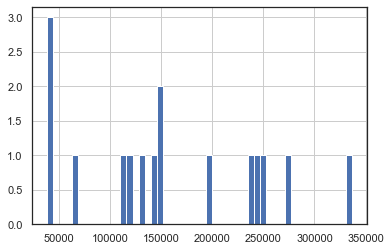

In [9]:
video_file = 'IMG_0185'
temp_df = df[df.video == video_file][['face_size','avg_face','video']]
temp_df.face_size.hist(bins=50);

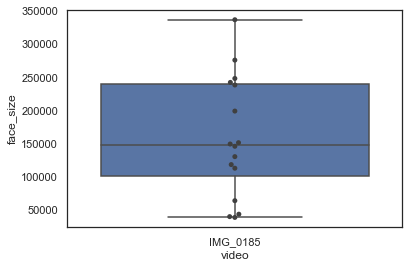

In [10]:
ax = sns.boxplot(x="video", y="face_size", data=temp_df)
ax = sns.swarmplot(x="video", y="face_size", data=temp_df, color=".25")

In [11]:
temp_df.sort_values('face_size')

face_size     avg_face     video
13    38809.0000  149308.6875  IMG_0185
808   40000.0000  149308.6875  IMG_0185
0     43681.0000  149308.6875  IMG_0185
809   64009.0000  149308.6875  IMG_0185
1    112896.0000  149308.6875  IMG_0185
11   118336.0000  149308.6875  IMG_0185
2    130321.0000  149308.6875  IMG_0185
3    145924.0000  149308.6875  IMG_0185
10   149308.6875  149308.6875  IMG_0185
4    151321.0000  149308.6875  IMG_0185
12   198916.0000  149308.6875  IMG_0185
5    238144.0000  149308.6875  IMG_0185
6    242064.0000  149308.6875  IMG_0185
7    248004.0000  149308.6875  IMG_0185
8    275625.0000  149308.6875  IMG_0185
9    336400.0000  149308.6875  IMG_0185

In [12]:
# Use frames from 12 videos as test set
test_video = df.groupby('video').count().iloc[10:22,:].index.tolist()
len(test_video)

12

In [13]:
# Separate features and target
X = df.iloc[:,:-4]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)


# Manual tran test split
X_train_df = df[~df.video.isin(test_video)].iloc[:,:-4]
X_test_df = df[df.video.isin(test_video)].iloc[:,:-4]

y_train = df[~df.video.isin(test_video)]['label'].map(mapping)
y_test = df[df.video.isin(test_video)]['label'].map(mapping)

In [14]:
len(X_train_df),len(X_test_df)

(1704, 128)

### Reset train_df and test_df index

In [15]:
# Reset index
X_train_df.reset_index(inplace=True,drop=True)
X_test_df.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [16]:
X_test_df

filename     lp_cat      lp_all  lp_ratio  lp_cat_canny  \
0    IMG_0253.MOV_144.jpg   2.386208   51.840806  0.046030  15310.361060   
1    IMG_0253.MOV_162.jpg   1.654996   39.046600  0.042385  13118.477750   
2    IMG_0253.MOV_168.jpg   1.448652   46.981061  0.030835  20798.123650   
3    IMG_0253.MOV_174.jpg   1.641137   76.725604  0.021390  34971.160718   
4    IMG_0257.MOV_120.jpg  38.872382  109.691005  0.354381  19225.445776   
..                    ...        ...         ...       ...           ...   
123  IMG_3554.MOV_363.jpg   6.893756   51.391806  0.134141  22734.425657   
124  IMG_3554.MOV_396.jpg  17.863301   56.146853  0.318153  27843.528360   
125  IMG_3554.MOV_399.jpg   6.688418   51.959772  0.128723  26900.606564   
126  IMG_3554.MOV_402.jpg   6.650422   52.345171  0.127049  25497.761660   
127   IMG_3555.MOV_57.jpg  32.822912   65.508827  0.501046   5961.773084   

     lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x     cat_y  \
0     2186.095590        7.003519     0  234.931905  0.397396  0.618519   
1      633.441839       20.709838     0  205.572372  0.398958  0.437037   
2     5401.785044        3.850232     0  124.326184  0.438021  0.466667   
3    16892.263211        2.070247     1   61.554854  0.476562  0.538889   
4     9973.604492        1.927633     0  750.345254  0.104630  0.178646   
..            ...             ...   ...         ...       ...       ...   
123   2815.084526        8.075930     0  529.060488  0.010185  0.495833   
124   3864.591037        7.204780     0  386.959946  0.154630  0.446354   
125   3360.847981        8.004113     0  364.967122  0.175000  0.447917   
126   3533.131619        7.216760     0  358.711583  0.182407  0.445312   
127   1702.641493        3.501485     0  661.420441  0.054630  0.263542   

     face_size  size_ratio                                               eyes  \
0      67600.0    0.032600           [(802, 701, 75, 77), (921, 748, 53, 71)]   
1      47524.0    0.022919                                                 []   
2      34596.0    0.016684                                                 []   
3      28900.0    0.013937                               [(936, 610, 29, 51)]   
4     208849.0    0.100718         [(393, 452, 93, 108), (191, 502, 120, 95)]   
..         ...         ...                                                ...   
123    68121.0    0.032852  [(371, 963, 74, 117), (32, 1028, 90, 65), (175...   
124    78961.0    0.038079                               [(217, 948, 69, 64)]   
125    70225.0    0.033866           [(228, 945, 71, 62), (351, 958, 70, 59)]   
126    70225.0    0.033866           [(240, 943, 70, 57), (368, 958, 64, 48)]   
127   173889.0    0.083859          [(134, 643, 94, 99), (314, 633, 106, 96)]   

                                             ears                   nose  \
0                          [[755, 466, 121, 137]]   [[873, 831, 46, 52]]   
1                                              []   [[869, 606, 44, 43]]   
2                                              []   [[916, 617, 42, 42]]   
3                                              []   [[989, 690, 39, 38]]   
4     [[380, 139, 202, 196], [12, 224, 199, 208]]   [[325, 632, 83, 69]]   
..                                            ...                    ...   
123                        [[401, 684, 164, 169]]  [[102, 1095, 73, 72]]   
124                        [[133, 745, 116, 173]]  [[260, 1026, 71, 64]]   
125                        [[139, 751, 126, 153]]  [[277, 1019, 75, 55]]   
126  [[142, 761, 124, 151], [394, 783, 102, 112]]                     []   
127                         [[39, 478, 111, 123]]   [[226, 737, 92, 81]]   

     num_eye  num_ear  num_nose  eye_x1  eye_y1  eye_x2  eye_y2  eye_w1  \
0          2        1         1     802     701     921     748      75   
1          0        0         1       0       0       0       0       0   
2          0        0         1       0       0       0       0       0   
3          1     

In [17]:
X_test_df.columns

Index(['filename', 'lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny',
       'lp_all_canny', 'lp_ratio_canny', 'blur', 'to_ctr', 'cat_x', 'cat_y',
       'face_size', 'size_ratio', 'eyes', 'ears', 'nose', 'num_eye', 'num_ear',
       'num_nose', 'eye_x1', 'eye_y1', 'eye_x2', 'eye_y2', 'eye_w1', 'eye_w2',
       'eye_w', 'eye_h1', 'eye_h2', 'eye_h', 'eye_size', 'eye_ratio', 'nose_x',
       'nose_y', 'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h'],
      dtype='object')

In [18]:
X_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   filename        128 non-null    object 
 1   lp_cat          128 non-null    float64
 2   lp_all          128 non-null    float64
 3   lp_ratio        128 non-null    float64
 4   lp_cat_canny    128 non-null    float64
 5   lp_all_canny    128 non-null    float64
 6   lp_ratio_canny  128 non-null    float64
 7   blur            128 non-null    int64  
 8   to_ctr          128 non-null    float64
 9   cat_x           128 non-null    float64
 10  cat_y           128 non-null    float64
 11  face_size       128 non-null    float64
 12  size_ratio      128 non-null    float64
 13  eyes            128 non-null    object 
 14  ears            128 non-null    object 
 15  nose            128 non-null    object 
 16  num_eye         128 non-null    int64  
 17  num_ear         128 non-null    int

In [19]:
y_test

0      0
1      0
2      0
3      0
4      0
      ..
123    1
124    1
125    1
126    1
127    1
Name: label, Length: 128, dtype: int64

## Scale continuous variables

In [20]:
headers = ['filename','lp_cat','lp_all','lp_ratio','lp_cat_canny','lp_all_canny','lp_ratio_canny','blur',\
               'to_ctr','cat_x','cat_y','face_size','size_ratio',\
               'eyes','ears','nose']

In [21]:
# Continuous variables
features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny',\
#             'cat_x', 'cat_y',
            'face_size', 'size_ratio', 'to_ctr',\
            'num_eye','num_ear', 'num_nose', 
            'eye_w1', 'eye_w2', 'eye_w', 'eye_h1', 'eye_h2', 'eye_h',
            'eye_size', 'eye_ratio',
            'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h',
#             'eye_x1', 'eye_y1', 'eye_x2', 'eye_y2',
#             'nose_x'
           ]
X_train_con = X_train_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train_con_scaled = scaler.fit_transform(X_train_df[features])
cont_columns = X_train_con.columns
X_train_con_df = pd.DataFrame(X_train_con_scaled, columns=cont_columns, index=X_train_con.index)
# X_train_con_df

In [22]:
# Try without 'blur'
X_train = X_train_con_df

In [23]:
# # Combine Con and Cat
# X_train = pd.concat([X_train_con_df,X_train_df[['blur']]], axis='columns')
# X_train

In [24]:
# Repeat for test set
# Continuous variables
# features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny', 'size_ratio', 'to_ctr']
X_test_con = X_test_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_test_con_scaled = scaler.fit_transform(X_test_df[features])
cont_columns = X_test_con.columns
X_test_con_df = pd.DataFrame(X_test_con_scaled, columns=cont_columns, index=X_test_con.index)

# Combine Con and Cat
X_test = pd.concat([X_test_con_df,X_test_df[['blur']]], axis='columns')
X_test

lp_cat    lp_all  lp_ratio  lp_cat_canny  lp_all_canny  lp_ratio_canny  \
0   -0.602344 -1.052058 -0.624786     -0.431543     -0.763044        1.040416   
1   -0.611053 -1.326168 -0.629732     -0.560931     -0.881224        5.262947   
2   -0.613511 -1.156176 -0.645408     -0.107599     -0.518284        0.068977   
3   -0.611219 -0.518914 -0.658226      0.729041      0.356309       -0.479387   
4   -0.167762  0.187354 -0.206309     -0.200434     -0.170302       -0.523322   
..        ...       ...       ...           ...           ...             ...   
123 -0.548655 -1.061678 -0.505206      0.006702     -0.715169        1.370795   
124 -0.417998 -0.959803 -0.255475      0.308294     -0.635287        1.102419   
125 -0.551101 -1.049509 -0.512559      0.252633     -0.673629        1.348671   
126 -0.551554 -1.041252 -0.514831      0.169823     -0.660515        1.106109   
127 -0.239816 -0.759227 -0.007264     -0.983394     -0.799842       -0.038463   

     face_size  size_ratio    to_ctr   num_eye   num_ear  num_nose    eye_w1  \
0    -0.630618   -0.572942 -1.547337  0.414483 -0.199047  0.367230 -0.170106   
1    -0.774299   -0.713426 -1.691575 -2.111888 -1.472947  0.367230 -1.597570   
2    -0.866823   -0.803892 -2.090724 -2.111888 -1.472947  0.367230 -1.597570   
3    -0.907589   -0.843750 -2.399108 -0.848703 -1.472947  0.367230 -1.045618   
4     0.380280    0.415467  0.984800  0.414483  1.074853  0.367230  0.172485   
..         ...         ...       ...       ...       ...       ...       ...   
123  -0.626890   -0.569296 -0.102334  2.940853 -0.199047  0.367230 -0.189139   
124  -0.549309   -0.493442 -0.800449 -0.848703 -0.199047  0.367230 -0.284303   
125  -0.611832   -0.554573 -0.908496  0.414483 -0.199047  0.367230 -0.246238   
126  -0.611832   -0.554573 -0.939228  0.414483  1.074853 -2.397794 -0.265270   
127   0.130076    0.170829  0.547928  0.414483 -0.199047  0.367230  0.191518   

       eye_w2     eye_w    eye_h1    eye_h2     eye_h  eye_size  eye_ratio  \
0   -0.443084 -0.423193 -0.045897  0.023627 -0.099306 -0.455752  -0.158669   
1   -1.303874 -1.625167 -1.733793 -1.326820 -1.721069 -0.942517  -0.327732   
2   -1.303874 -1.625167 -1.733793 -1.326820 -1.721069 -0.942517  -0.327732   
3   -1.303874 -1.080522 -0.615836 -1.326820 -0.603367 -0.790506  -0.204236   
4    0.645085  0.374993  0.633646  0.480116  0.503377  0.168507  -0.202831   
..        ...       ...       ...       ...       ...       ...        ...   
123  0.157845  0.079195  0.830933 -0.090495  0.169162 -0.138041  -0.050459   
124 -1.303874 -0.329288 -0.330866 -1.326820 -0.318463 -0.488642  -0.192774   
125 -0.166981 -0.301117 -0.374708 -0.204618 -0.395168 -0.504136  -0.181165   
126 -0.264429 -0.366850 -0.484311 -0.413842 -0.570494 -0.580989  -0.206860   
127  0.417706  0.252918  0.436360  0.499136  0.415714  0.059586  -0.192426   

       ear_w1    ear_w2     ear_w    ear_h1    ear_h2     ear_h  blur  
0   -0.207314 -0.752085 -0.192305 -0.138598 -0.737439 -0.098396     0  
1   -1.395206 -0.752085 -1.442164 -1.325340 -0.737439 -1.365726     0  
2   -1.395206 -0.752085 -1.442164 -1.325340 -0.737439 -1.365726     0  
3   -1.395206 -0.752085 -1.442164 -1.325340 -0.737439 -1.365726     1  
4    0.587887  1.243654  0.628884  0.372481  1.254604  0.502892     0  
..        ...       ...       ...       ...       ...       ...   ...  
123  0.214830 -0.752085  0.251860  0.138598 -0.737439  0.197623     0  
124 -0.256400 -0.752085 -0.243952  0.173247 -0.737439  0.234625     0  
125 -0.158227 -0.752085 -0.140658  0.000000 -0.737439  0.049613     0  
126 -0.177862  0.270857 -0.274940 -0.017325  0.335200 -0.149274     0  
127 -0.305486 -0.752085 -0.295599 -0.259871 -0.737439 -0.227904     0  

[128 rows x 27 columns]

In [25]:
# Try without 'blur'
X_test = X_test_con_df

## 1. Logistic regression

### A. Basic

In [26]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
print('intercept: ', round(lm.intercept_[0], 4))
pd.DataFrame(list(zip(X_train.columns,np.transpose(lm.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

intercept:  0.258


Feature                    Coef
7       size_ratio     [2.289775629355762]
20          ear_w1    [2.2647754432688485]
12          eye_w1    [1.9253633109947772]
3     lp_cat_canny    [1.9240491162973523]
16          eye_h2    [1.3427983415406761]
0           lp_cat    [1.1124302629195926]
9          num_eye    [0.7673854973924334]
21          ear_w2    [0.5512035236324901]
15          eye_h1   [0.20155094290006786]
4     lp_all_canny   [0.16237201203923488]
19       eye_ratio    [0.1098757849106915]
11        num_nose   [0.04850599835356551]
24          ear_h2   [-0.0556398104777698]
10         num_ear   [-0.2700611903778492]
5   lp_ratio_canny   [-0.2719054473733049]
13          eye_w2  [-0.29434792590413267]
14           eye_w    [-0.353712087452666]
17           eye_h  [-0.37805505275938023]
25           ear_h  [-0.42789588771507275]
23          ear_h1  [-0.47158481649247813]
8           to_ctr   [-0.6058654974434998]
6        face_size    [-0.745961909714644]
1           lp_all   [-1.1552905617254572]
22           ear_w   [-1.1845233768870989]
2         lp_ratio   [-1.2494217407903663]
18        eye_size   [-2.9028907670067485]

In [27]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)                45                41
Good (1)                6                36

In [28]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion/np.sum(fraud_confusion), cmap=plt.cm.Blues,
           annot=True, square=True, fmt='.2%',
           xticklabels=['Bad', 'Good'],
           yticklabels=['Bad', 'Good']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [29]:
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [30]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.6328125 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.88      0.52      0.66        86
           1       0.47      0.86      0.61        42

    accuracy                           0.63       128
   macro avg       0.67      0.69      0.63       128
weighted avg       0.75      0.63      0.64       128



In [31]:
# Define plot_roc function
def plot_roc(model_name,model):
    y_scores = model.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC of '+ model_name)
    plt.show()

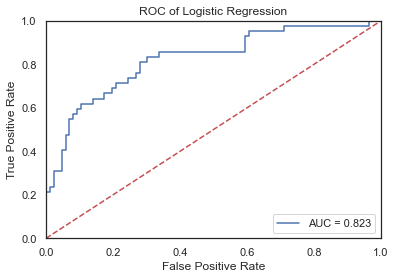

In [32]:
# Logistic regression ROC curve
plot_roc('Logistic Regression', lm)

### B. Hyperparameter Tuning

In [33]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [34]:
# note that train and validation sets are not split properly!

In [35]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.810243 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


In [36]:
# Use best model on test set
lm_best = grid_result.estimator
lm_best.fit(X_train,y_train)
y_predict = lm_best.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)                46                40
Good (1)                6                36

In [37]:
print('intercept: ', round(lm.intercept_[0], 4))
pd.DataFrame(list(zip(X_train.columns,np.transpose(lm_best.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False).head(5)

intercept:  0.258


Feature                  Coef
7     size_ratio  [1.8968350094218698]
3   lp_cat_canny   [1.764587484217256]
20        ear_w1  [1.5892748984125218]
12        eye_w1   [1.425841478223297]
16        eye_h2   [1.191595314084025]

In [38]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.640625 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.88      0.53      0.67        86
           1       0.47      0.86      0.61        42

    accuracy                           0.64       128
   macro avg       0.68      0.70      0.64       128
weighted avg       0.75      0.64      0.65       128



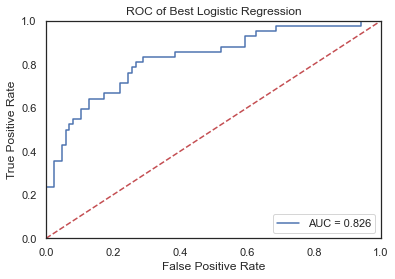

In [39]:
# Logistic regression ROC curve
plot_roc('Best Logistic Regression', lm_best)

In [40]:
# Only small improvement compared to the basic model!

## 2. Random Forests

### A. Basic

In [41]:
def quick_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

def quick_test_afew_times(model, X_train, y_train, X_test, y_test, n=10):
    return np.mean([quick_test(model, X_train, y_train, X_test, y_test) for j in range(n)])

In [42]:
from sklearn.ensemble import RandomForestClassifier
# Random Forests
randomforest = RandomForestClassifier(n_estimators=200)
quick_test_afew_times(randomforest, X_train, y_train, X_test, y_test)

0.80703125

In [43]:
# Save the model! (pickle)
import pickle
randomforest.fit(X_train, y_train)
pickle.dump(randomforest, open('./dump/randomforest.pkl','wb'))

In [44]:
pred = randomforest.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Random Forests):\n\n',classification_report(y_test,pred))

Accuracy score: 0.8203125 

Classification report (Random Forests):

               precision    recall  f1-score   support

           0       0.86      0.87      0.87        86
           1       0.73      0.71      0.72        42

    accuracy                           0.82       128
   macro avg       0.80      0.79      0.79       128
weighted avg       0.82      0.82      0.82       128



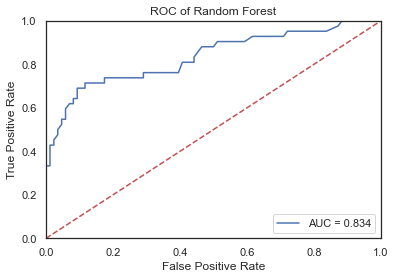

In [45]:
# Random Forest ROC curve
plot_roc('Random Forest', randomforest)

In [46]:
interactive(lambda threshold: make_confusion_matrix(randomforest, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [47]:
# y_scores

### B. Hyperparameter Tuning
The most important parameter is the number of random features to sample at each split point (max_features).  Another important parameter for random forest is the number of trees (n_estimators). Ideally, this should be increased until no further improvement is seen in the model.

In [48]:
# # define models and parameters
# model = RandomForestClassifier()
# n_estimators = [10, 100, 1000]
# max_features = ['sqrt', 'log2']
# # define grid search
# grid = dict(n_estimators=n_estimators,max_features=max_features)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)

In [49]:
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# # for mean, stdev, param in zip(means, stds, params):
# #     print("%f (%f) with: %r" % (mean, stdev, param))

In [50]:
# # Use best model on test set
# rf_best = grid_result.estimator
# rf_best.fit(X_train,y_train)
# y_predict = rf_best.predict(X_test)
# pd.DataFrame(confusion_matrix(y_test, y_predict),\
#              columns=['Predict-Bad (0)','Predict-Good (1)'],\
#             index=['Bad (0)','Good (1)'])

In [51]:
# pred = randomforest.predict(X_test)
# print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
# print('Classification report (Random Forests):\n\n',classification_report(y_test,y_predict))

In [52]:
# # Random Forests ROC curve
# y_scores = rf_best.predict_proba(X_test)
# fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, 'b', label = 'AUC_forests = %0.3f' % roc_auc)

# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.title('ROC of Random Forests')
# plt.show()

In [53]:
# Not necessarily better

### C. Feature importatnce

In [54]:
pd.DataFrame(list(zip(X_train.columns,np.transpose(randomforest.feature_importances_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

Feature      Coef
3     lp_cat_canny  0.084981
1           lp_all  0.084650
4     lp_all_canny  0.070451
16          eye_h2  0.068526
5   lp_ratio_canny  0.065991
13          eye_w2  0.056802
15          eye_h1  0.047350
19       eye_ratio  0.045152
8           to_ctr  0.044920
7       size_ratio  0.042793
0           lp_cat  0.042409
9          num_eye  0.041682
2         lp_ratio  0.039628
6        face_size  0.034712
17           eye_h  0.031583
18        eye_size  0.030600
25           ear_h  0.024764
12          eye_w1  0.023956
14           eye_w  0.022750
20          ear_w1  0.022199
22           ear_w  0.019104
23          ear_h1  0.017364
21          ear_w2  0.013053
24          ear_h2  0.011913
10         num_ear  0.008500
11        num_nose  0.004167

In [55]:
# Logistic regression has higher AUC score
# But Random forest has better precision

## 3. AdaBoost

In [56]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [57]:
pred = ada.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,ada.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (AdaBoost):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7578125
ROC AUC score: 0.807170542635659 

Classification report (AdaBoost):

               precision    recall  f1-score   support

           0       0.86      0.77      0.81        86
           1       0.61      0.74      0.67        42

    accuracy                           0.76       128
   macro avg       0.73      0.75      0.74       128
weighted avg       0.78      0.76      0.76       128



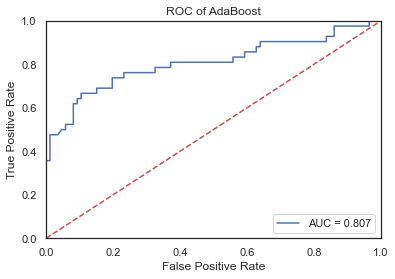

In [58]:
# AdaBoost ROC curve
plot_roc('AdaBoost', ada)

## 4. Gradient Boost

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

In [60]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                max_depth=1, random_state=0).fit(X_train, y_train)

In [61]:
pred = gb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,gb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7109375
ROC AUC score: 0.8001107419712071 

Classification report (XGBoost):

               precision    recall  f1-score   support

           0       0.87      0.67      0.76        86
           1       0.54      0.79      0.64        42

    accuracy                           0.71       128
   macro avg       0.70      0.73      0.70       128
weighted avg       0.76      0.71      0.72       128



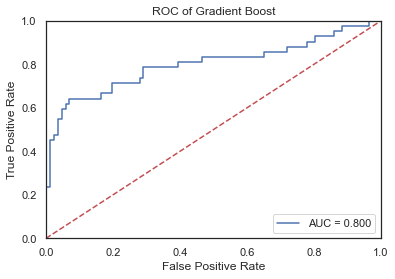

In [62]:
# Gradient Boost ROC curve
plot_roc('Gradient Boost', gb)

## 5. XGBoost

In [63]:
X_train.columns
# X_train.columns[X_train.columns.duplicated()]

Index(['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny',
       'lp_ratio_canny', 'face_size', 'size_ratio', 'to_ctr', 'num_eye',
       'num_ear', 'num_nose', 'eye_w1', 'eye_w2', 'eye_w', 'eye_h1', 'eye_h2',
       'eye_h', 'eye_size', 'eye_ratio', 'ear_w1', 'ear_w2', 'ear_w', 'ear_h1',
       'ear_h2', 'ear_h'],
      dtype='object')

In [64]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
pred = xgb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,xgb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

Accuracy score: 0.765625
ROC AUC score: 0.8230897009966778 

Classification report (XGBoost):

               precision    recall  f1-score   support

           0       0.86      0.78      0.82        86
           1       0.62      0.74      0.67        42

    accuracy                           0.77       128
   macro avg       0.74      0.76      0.75       128
weighted avg       0.78      0.77      0.77       128



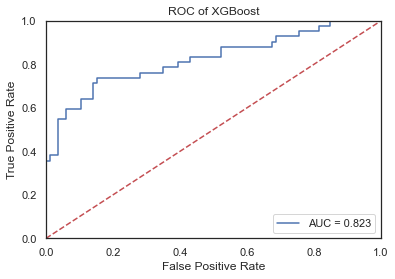

In [66]:
# XGBoost ROC curve
plot_roc('XGBoost', xgb)

## Examine model results

### 1. Check the best frame for each video file

In [67]:
# Specify the model to check
model = lm_best
# model = randomforest
# model = xgb
# model = ada

In [68]:
test_df = df[df.video.isin(test_video)].reset_index(drop=True)
# [['video','filename','label']]

threshold = 0.56
y_predict = (model.predict_proba(X_test)[:, 1] >= threshold).tolist()
test_df['label'] = y_test
test_df['pred'] = [0 if x==False else 1 for x in y_predict]
test_df['prob'] = model.predict_proba(X_test)[:, 1]

In [69]:
# test_df

In [70]:
test_df['prob_max'] = test_df.groupby(['video'])['prob'].transform(max)

In [71]:
pd.set_option('display.max_columns', None)
test_df[test_df.video=="IMG_0253"].drop(columns=['eyes','ears','nose','video']).sort_values('prob',ascending=False)

filename    lp_cat     lp_all  lp_ratio  lp_cat_canny  \
86  IMG_0253.MOV_150.jpg  2.472868  53.984868  0.045807  28690.978944   
0   IMG_0253.MOV_144.jpg  2.386208  51.840806  0.046030  15310.361060   
87  IMG_0253.MOV_156.jpg  2.414697  52.078203  0.046367  19410.692181   
3   IMG_0253.MOV_174.jpg  1.641137  76.725604  0.021390  34971.160718   
88  IMG_0253.MOV_180.jpg  1.586603  39.709572  0.039955  30942.399234   
2   IMG_0253.MOV_168.jpg  1.448652  46.981061  0.030835  20798.123650   
1   IMG_0253.MOV_162.jpg  1.654996  39.046600  0.042385  13118.477750   

    lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x     cat_y  \
86   4049.574865        7.084936     0  216.085631  0.392188  0.557407   
0    2186.095590        7.003519     0  234.931905  0.397396  0.618519   
87   1944.290148        9.983434     0  211.021326  0.390104  0.502778   
3   16892.263211        2.070247     1   61.554854  0.476562  0.538889   
88   2100.675019       14.729741     0   22.847319  0.495312  0.519444   
2    5401.785044        3.850232     0  124.326184  0.438021  0.466667   
1     633.441839       20.709838     0  205.572372  0.398958  0.437037   

    face_size  size_ratio  num_eye  num_ear  num_nose  eye_x1  eye_y1  eye_x2  \
86    62500.0    0.030141        2        1         1     791     642     901   
0     67600.0    0.032600        2        1         1     802     701     921   
87    61504.0    0.029660        2        1         1     788     593     898   
3     28900.0    0.013937        1        0         1     936     610       0   
88    27556.0    0.013289        0        0         1       0       0       0   
2     34596.0    0.016684        0        0         1       0       0       0   
1     47524.0    0.022919        0        0         1       0       0       0   

    eye_y2  eye_w1  eye_w2  eye_w  eye_h1  eye_h2  eye_h  eye_size  eye_ratio  \
86     682      63      53   58.0      72      64   68.0    3944.0   0.063104   
0      748      75      53   64.0      77      71   74.0    4736.0   0.070059   
87     623      58      40   49.0      72      56   64.0    3136.0   0.050989   
3        0      29       0   29.0      51       0   51.0    1479.0   0.051176   
88       0       0       0    0.0       0       0    0.0       0.0   0.000000   
2        0       0       0    0.0       0       0    0.0       0.0   0.000000   
1        0       0       0    0.0       0       0    0.0       0.0   0.000000   

    nose_x  nose_y  ear_w1  ear_w2  ear_w  ear_h1  ear_h2  ear_h  \
86     854     762     126       0  126.0     153       0  153.0   
0      873     831     121       0  121.0     137       0  137.0   
87     860     699     116       0  116.0     162       0  162.0   
3      989     690       0       0    0.0       0       0    0.0   
88    1030     668       0       0    0.0       0       0    0.0   
2      916     617       0       0    0.0       0       0    0.0   
1      869     606       0       0    0.0       0       0    0.0   

        avg_face  avg_to_ctr  label  pred      prob  prob_max  
86  47168.571429  153.762799      1     1  0.925583  0.925583  
0   47168.571429  153.762799      0     1  0.815219  0.925583  
87  47168.571429  153.762799      1     1  0.770294  0.925583  
3   47168.571429  153.762799      0     1  0.754336  0.925583  
88  47168.571429  153.762799      1     0  0.357647  0.925583  
2   47168.571429  153.762799      0     0  0.229201  0.925583  
1   47168.571429  153.762799      0     0  0.038127  0.925583

In [72]:
# randomforest
results = test_df[test_df['prob'] == test_df['prob_max']][['video','filename','label','prob']]
results

video              filename  label      prob
32   IMG_0259   IMG_0259.MOV_78.jpg      0  0.614774
39   IMG_0262  IMG_0262.MOV_102.jpg      0  0.739124
81   IMG_3554  IMG_3554.MOV_384.jpg      0  0.979785
86   IMG_0253  IMG_0253.MOV_150.jpg      1  0.925583
92   IMG_0257  IMG_0257.MOV_168.jpg      1  0.882848
96   IMG_0258    IMG_0258.MOV_0.jpg      1  0.999393
108  IMG_0261  IMG_0261.MOV_228.jpg      1  0.996318
111  IMG_0263  IMG_0263.MOV_150.jpg      1  0.138355
113  IMG_0267  IMG_0267.MOV_204.jpg      1  0.767982
115  IMG_0268  IMG_0268.MOV_255.jpg      1  0.982966
122  IMG_0271  IMG_0271.MOV_222.jpg      1  0.919575
127  IMG_3555   IMG_3555.MOV_57.jpg      1  0.332163

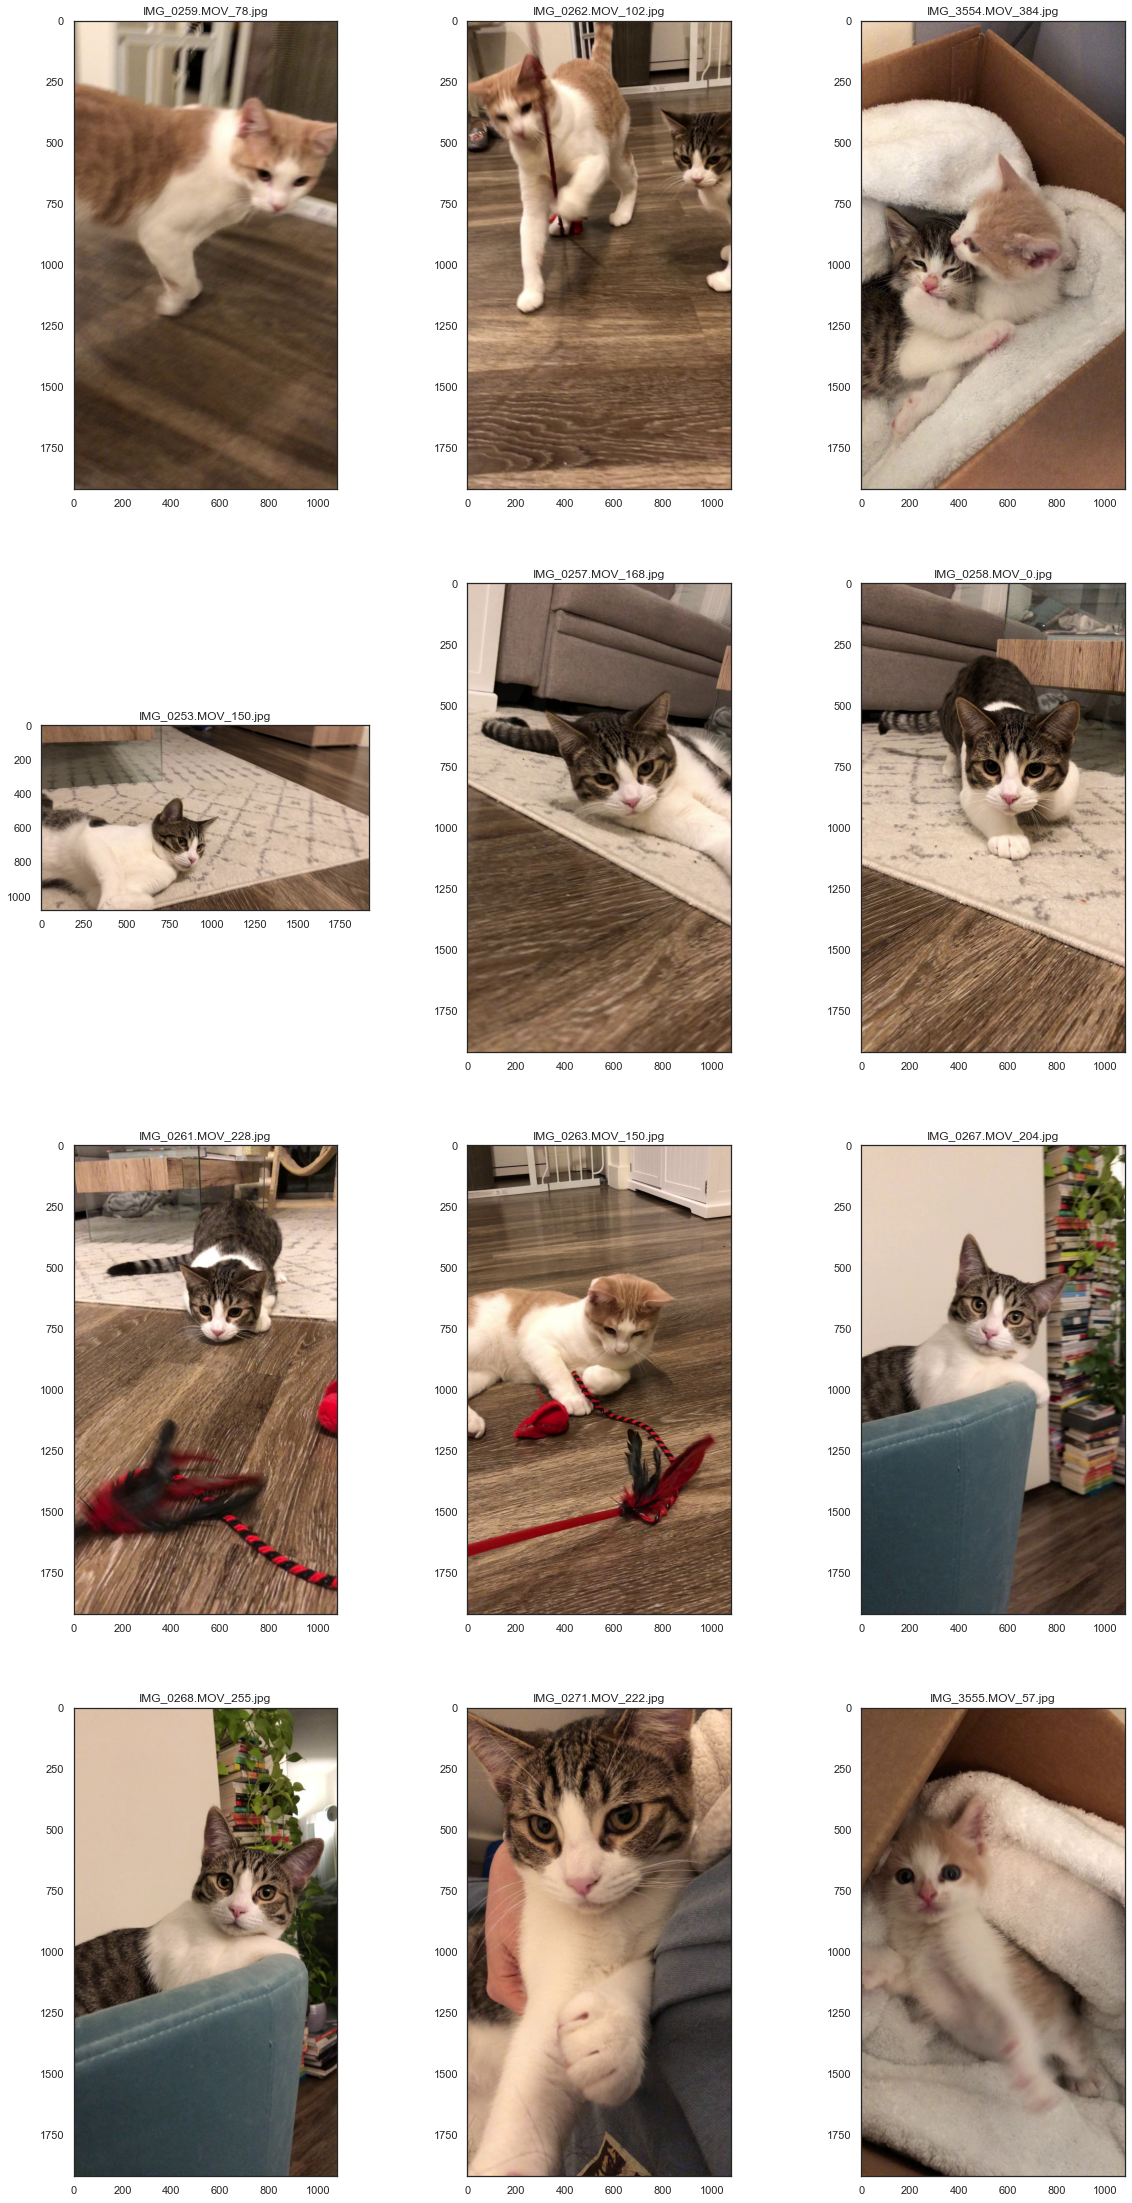

In [73]:
# Selected frame

import cv2 as cv

# Text parameters 
font = cv.FONT_HERSHEY_SIMPLEX
org = (800, 100)
fontScale = 2
color = (255, 0, 0)
thickness = 2

# List of lp_ratio
# lp_ratios = [round(x,4) for x in FP.lp_ratio.tolist()]

# Prepare list of best frames
selected_img = results.filename.tolist()
test_len = len(results)

# Plots
subplot_row = test_len//3+1
fig, axs = plt.subplots(figsize=(20, 10*subplot_row))
for i, filename in enumerate(selected_img[:]):
    img = cv.imread('OpenCV_blur/frame_all_1/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
#     # Annotate lp_ratio
#     lp_ratio = str(lp_ratios[i])
#     rgb = cv.putText(rgb, lp_ratio,org, font,  
#                    fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(subplot_row,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()

### Check false positive images

In [74]:
# False-positive: bad photos but predicted to be good
FP = test_df[(test_df.label==0) & (test_df.pred==1)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

34

In [75]:
# False-positive: bad photos but predicted to be good
FP = results[(results.label==0)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

3

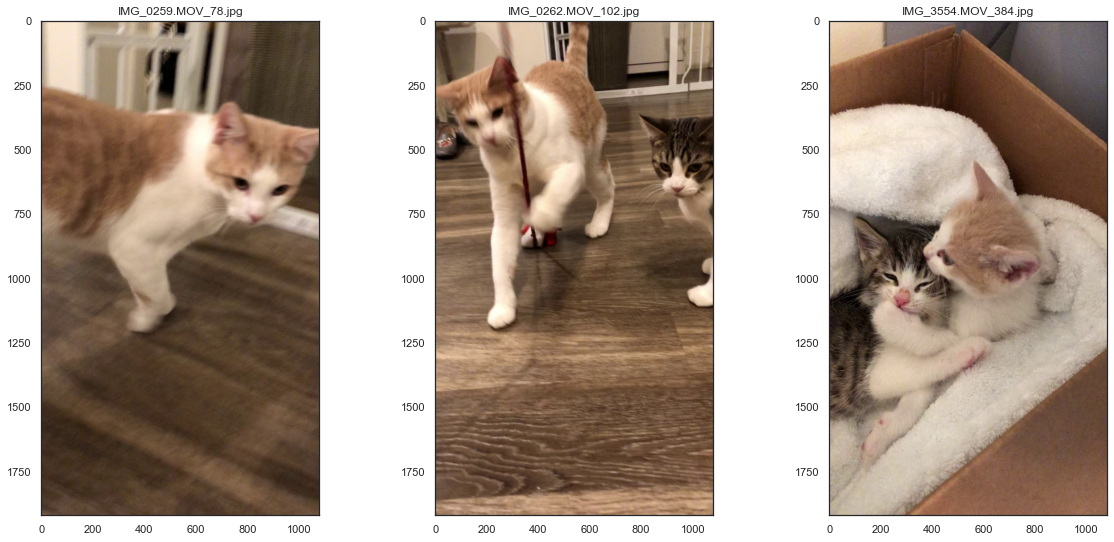

In [76]:
import cv2 as cv

# Plots
subplot_row = FP_len//3+1
fig, axs = plt.subplots(figsize=(20, 10*subplot_row))
for i, filename in enumerate(FP_img[:]):
    img = cv.imread('OpenCV_blur/frame_all_1/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
#     # Annotate lp_ratio
#     lp_ratio = str(lp_ratios[i])
#     rgb = cv.putText(rgb, lp_ratio,org, font,  
#                    fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(subplot_row,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()

In [77]:
# Went back to check the images
# These are not great but indeed are the best among the given options